In [89]:
import stat
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from scipy import stats

from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

import statsmodels.api as sm
from statsmodels.formula.api import ols

pd.set_option("display.max_rows", None, "display.max_columns", None)
RANDOM_STATE = 42


Load data

In [30]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

### Visualise dataset

In [31]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [32]:
test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Descriptives statistics

#### Find proportion of nan in columns

In [33]:
print("Train")
print(np.sum(train.isna(), axis=0) / train.shape[0] * 100)

print("\nTest")
print(np.sum(test.isna(), axis=0) / test.shape[0] * 100)

Train
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

Test
PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64


- **Age** : Imputation from other variable or create a categorical variable.
- **Cabin** : Too much missing data, will probably remove this variable or create a categorical variable with to level
(present / absent).
- **Fare** : Will probably try to impute a value to the missing data in the test set (from a model or the mean in the
training data)

#### Set type of some columns to **str**

In [34]:
for column in ["Name", "Sex", "Ticket", "Cabin", "Embarked"]:
    test[column] = test[column].astype(str)
    train[column] = train[column].astype(str)

train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

#### Find number of unique values in each columns
- Train :

In [35]:
for column in train.columns:
    values = train[column].unique().tolist()
    values.sort()
    print("{} : {} ({})".format(column, len(values), values))

PassengerId : 891 ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218

- Test :

In [36]:
for column in test.columns:
    values = test[column].unique().tolist()
    values.sort()
    print("{} : {} ({})".format(column, len(values), values))

PassengerId : 418 ([892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 10

#### Notes on variables

- PassengerId : One by passenger, no correlation possible.
- Name : One by passenger.
- Cabin : To much missing value. Can create binary variable (variable is NA or got cabin information).
- Ticket : To much unique value to find pattern and duplicate (is it normal to have duplicate ??).

#### Create variable with Cabin variable

In [37]:
train["got_Cabin"] = ~(train["Cabin"] == "nan")
test["got_Cabin"] = ~(test["Cabin"] == "nan")

#### Visualisation : Categorical variable

- Train :

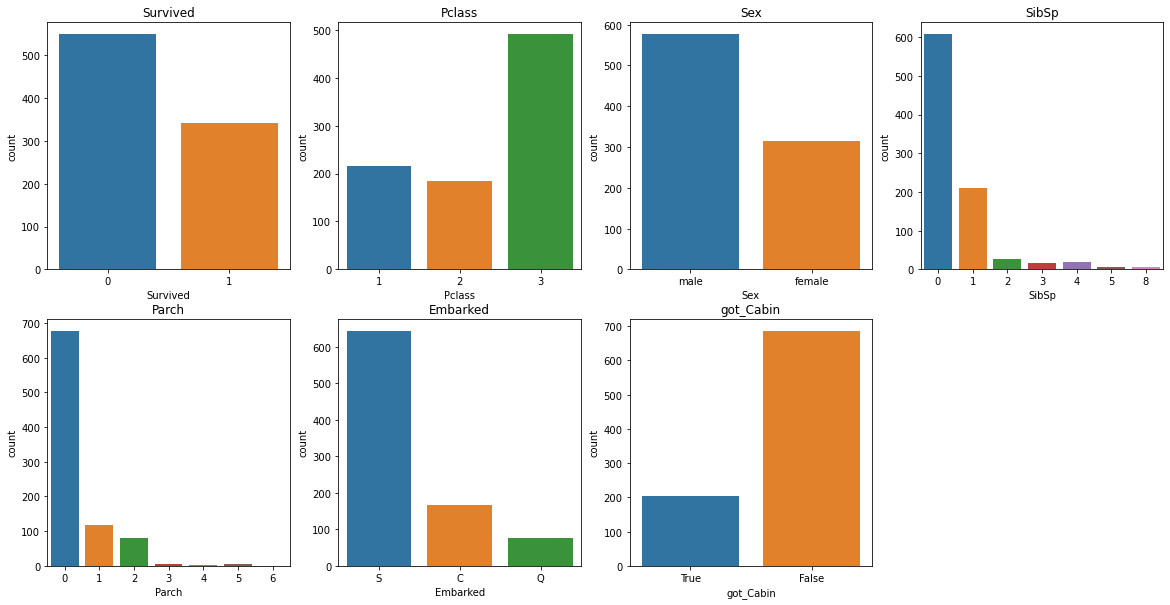

In [38]:
f, axs = plt.subplots(2, 4, figsize=(20, 10))

sns.countplot(x="Survived",data=train, ax=axs[0, 0])
axs[0, 0].set_title("Survived")
sns.countplot(x="Pclass",data=train, ax=axs[0, 1])
axs[0, 1].set_title("Pclass")
sns.countplot(x="Sex",data=train, ax=axs[0, 2], order=["male", "female"])
axs[0, 2].set_title("Sex")
sns.countplot(x="SibSp",data=train, ax=axs[0, 3])
axs[0, 3].set_title("SibSp")
sns.countplot(x="Parch", data=train, ax=axs[1, 0])
axs[1, 0].set_title("Parch")
sns.countplot(x="Embarked", data=train, ax=axs[1, 1], order=["S", "C", "Q"])
axs[1, 1].set_title("Embarked")
sns.countplot(x="got_Cabin", data=train, ax=axs[1, 2], order=[True, False])
axs[1, 2].set_title("got_Cabin")
f.delaxes(axs[1, 3])

- Test :

Text(0.5, 1.0, 'got_Cabin')

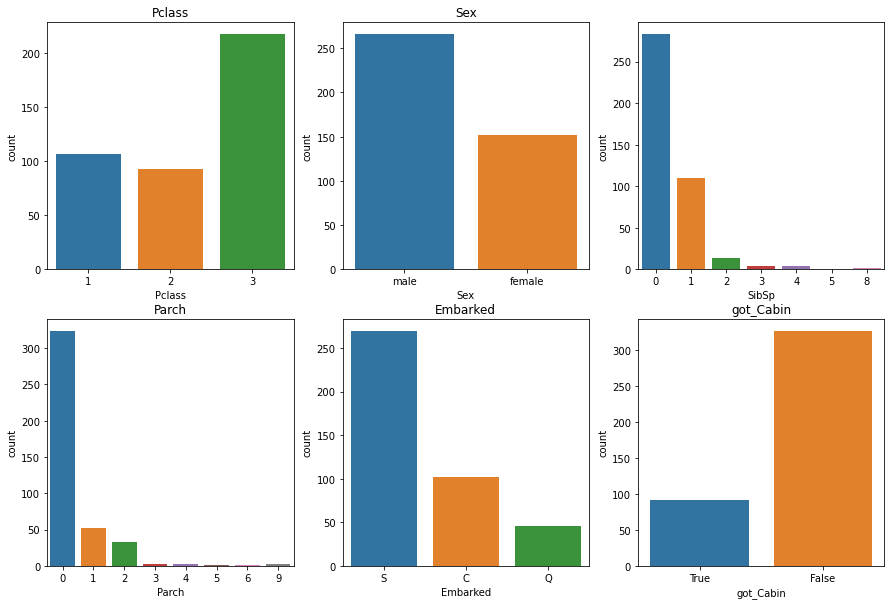

In [39]:
_, axs = plt.subplots(2, 3, figsize=(15, 10))

sns.countplot(x="Pclass",data=test, ax=axs[0, 0])
axs[0, 0].set_title("Pclass")
sns.countplot(x="Sex",data=test, ax=axs[0, 1],  order=["male", "female"])
axs[0, 1].set_title("Sex")
sns.countplot(x="SibSp",data=test, ax=axs[0, 2])
axs[1, 2].set_title("SibSp")
sns.countplot(x="Parch", data=test, ax=axs[1, 0])
axs[1, 0].set_title("Parch")
sns.countplot(x="Embarked", data=test, ax=axs[1, 1], order=["S", "C", "Q"])
axs[1, 1].set_title("Embarked")
sns.countplot(x="got_Cabin", data=test, ax=axs[1, 2], order=[True, False])
axs[1, 2].set_title("got_Cabin")

#### Visualisation distribution : numeric variable

- Age:

<AxesSubplot:ylabel='Frequency'>

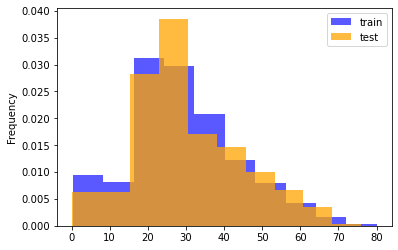

In [40]:
train["Age"].plot.hist(alpha=0.65, color="blue", label="train", legend=True, density=True)
test["Age"].plot.hist(alpha=0.75, color="orange", label="test", legend=True, density=True)

- Fare :


<AxesSubplot:ylabel='Frequency'>

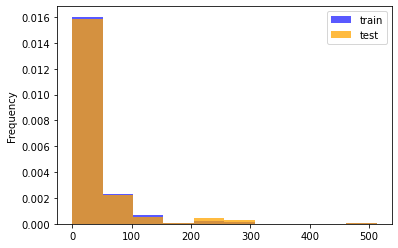

In [41]:
train["Fare"].plot.hist(alpha=0.65, color="blue", label="train", legend=True, density=True)
test["Fare"].plot.hist(alpha=0.75, color="orange", label="test", legend=True, density=True)


## Relation with variables with variable to predict

- Class : Less chance to survive in 3 class than the other class.

- Chi2 : 102.88898875696056 
- dof : 2 
- p-value : 4.549251711298793e-23


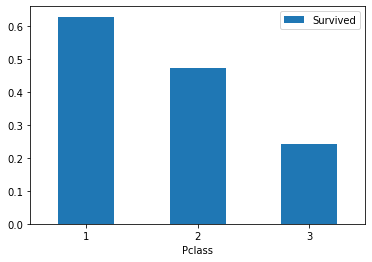

In [42]:
train[['Survived', 'Pclass']].groupby(['Pclass']).mean().plot.bar(y="Survived", rot=0)

t = stats.chi2_contingency(pd.crosstab(train["Survived"], train["Pclass"]))
print("- Chi2 : {} \n"
      "- dof : {} \n"
      "- p-value : {}".format(t[0], t[2], t[1]))

- Sex : Men have more likely to die and women more likely to live.

- Chi2 : 260.71702016732104 
- dof : 1 
- p-value : 1.1973570627755645e-58


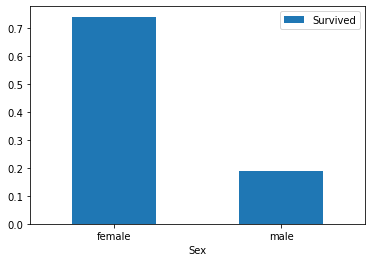

In [43]:
train[['Survived', 'Sex']].groupby(['Sex']).mean().plot.bar(y="Survived", rot=0)

t = stats.chi2_contingency(pd.crosstab(train["Survived"], train["Sex"]))
print("- Chi2 : {} \n"
      "- dof : {} \n"
      "- p-value : {}".format(t[0], t[2], t[1]))

- SibSp : Can create class 4/5 and more to help with test set.

- Chi2 : 37.27179291520431 
- dof : 6 
- p-value : 1.5585810465902116e-06


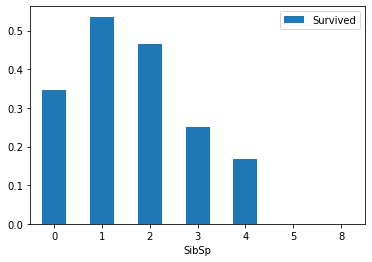

In [44]:
train[['Survived', 'SibSp']].groupby(['SibSp']).mean().plot.bar(y="Survived", rot=0)

t = stats.chi2_contingency(pd.crosstab(train["Survived"], train["SibSp"]))
print("- Chi2 : {} \n"
      "- dof : {} \n"
      "- p-value : {}".format(t[0], t[2], t[1]))

- Parch : Can create class 5 and more to help with test set.

- Chi2 : 27.925784060236168 
- dof : 6 
- p-value : 9.703526421039997e-05


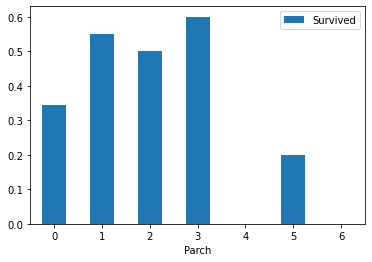

In [45]:
train[['Survived', 'Parch']].groupby(['Parch']).mean().plot.bar(y="Survived", rot=0)

t = stats.chi2_contingency(pd.crosstab(train["Survived"], train["Parch"]))
print("- Chi2 : {} \n"
      "- dof : {} \n"
      "- p-value : {}".format(t[0], t[2], t[1]))

- Embarked : C more likely to survive but not by a lot.

- Chi2 : 29.67061419139438 
- dof : 3 
- p-value : 1.61871880094504e-06


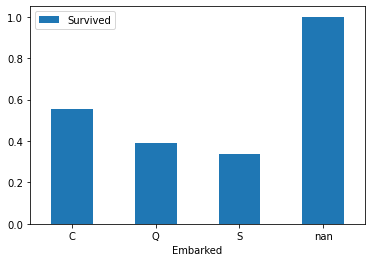

In [46]:
train[['Survived', 'Embarked']].groupby(['Embarked']).mean().plot.bar(y="Survived", rot=0)

t = stats.chi2_contingency(pd.crosstab(train["Survived"], train["Embarked"]))
print("- Chi2 : {} \n"
      "- dof : {} \n"
      "- p-value : {}".format(t[0], t[2], t[1]))

- got_Cabin : C more likely to survive but not by a lot.

- Chi2 : 87.94148561238097 
- dof : 1 
- p-value : 6.7419704360811776e-21


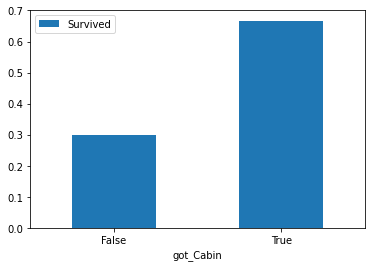

In [47]:
train[['Survived', 'got_Cabin']].groupby(['got_Cabin']).mean().plot.bar(y="Survived", rot=0)

t = stats.chi2_contingency(pd.crosstab(train["Survived"], train["got_Cabin"]))
print("- Chi2 : {} \n"
      "- dof : {} \n"
      "- p-value : {}".format(t[0], t[2], t[1]))

- Age :

                 sum_sq     df         F    PR(>F)
Survived     897.187582    1.0  4.271195  0.039125
Residual  149559.448362  712.0       NaN       NaN


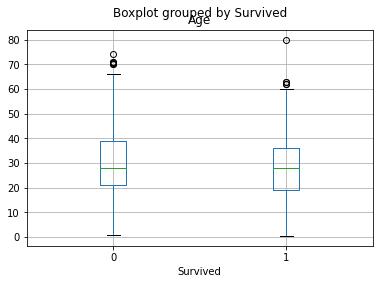

In [91]:
train.boxplot(column="Age", by="Survived")

mod = ols("Age ~ Survived", data=train).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

- Fare :

                sum_sq     df          F        PR(>F)
Survived  1.455089e+05    1.0  63.030764  6.120189e-15
Residual  2.052290e+06  889.0        NaN           NaN


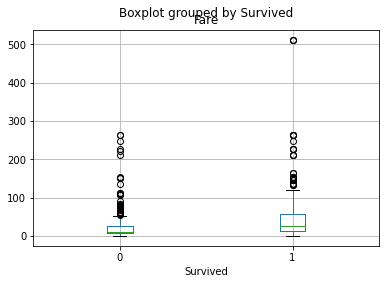

In [92]:
train.boxplot(column="Fare", by="Survived")

mod = ols("Fare ~ Survived", data=train).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

## Data imputation

#### Data modification

In [72]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

# Create new variables

train["got_Cabin"] = ~train["Cabin"].isna()
test["got_Cabin"] = ~test["Cabin"].isna()

# Keep test ID
test_PassengerId = test["PassengerId"]

# Drop useless column
train = train.drop(columns=["PassengerId"])
test = test.drop(columns=["PassengerId"])

train = train.drop(columns=["Name"])
test = test.drop(columns=["Name"])

train = train.drop(columns=["Cabin"])
test = test.drop(columns=["Cabin"])

train = train.drop(columns=["Ticket"])
test = test.drop(columns=["Ticket"])

# Set categorical variable to int
train["Sex"] = train["Sex"].map({"male": 0, "female": 1}).astype(int)
test["Sex"] = test["Sex"].map({"male": 0, "female": 1}).astype(int)

train.loc[~train["Embarked"].isna(), "Embarked"] = train.loc[~train["Embarked"].isna(), "Embarked"].map({"S": 0, "C": 1, "Q": 2}).astype(int)
test.loc[~test["Embarked"].isna(), "Embarked"] = test.loc[~test["Embarked"].isna(), "Embarked"].map({"S": 0, "C": 1, "Q": 2}).astype(int)

train["got_Cabin"] = train["got_Cabin"].map({False: 0, True: 1}).astype(int)
test["got_Cabin"] = test["got_Cabin"].map({False: 0, True: 1}).astype(int)

#### Modification categorical variable **Parch** and **SibSp**.

Gather class with few observation.

In [73]:
train.loc[train["Parch"] >= 3, "Parch"] = 3
test.loc[train["Parch"] >= 3, "Parch"] = 3

train.loc[train["SibSp"] >= 2, "SibSp"] = 2
test.loc[train["SibSp"] >= 2, "SibSp"] = 2

#### Imputation variable **Embarked** (train set)

We will simply put the most frequent value in the dataset.

In [74]:
embarked_na_index = train.index[train['Embarked'].isna()].tolist()
train.loc[embarked_na_index]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,got_Cabin
61,1,1,1,38.0,0,0,80.0,NaN,1
829,1,1,1,62.0,0,0,80.0,NaN,1


In [75]:
train.at[embarked_na_index, "Embarked"] = train["Embarked"].value_counts().idxmax()
train.loc[embarked_na_index]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,got_Cabin
61,1,1,1,38.0,0,0,80.0,0,1
829,1,1,1,62.0,0,0,80.0,0,1


#### Imputation variable age and fare.

We could have put nan values as mean or median, but we can also create a model that predict the value of the missing
value.

In [88]:
X_train, Y_train = train.loc[:, train.columns != 'Survived'], np.array(train["Survived"])
X_test = test

imputer = IterativeImputer(estimator=BayesianRidge(), n_nearest_features=None, imputation_order='ascending',
                           random_state=RANDOM_STATE)
imputer.fit(X_train)

X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

#### Scale [0, 1] Flare and Age variables

In [81]:
# Train
X_train[:, 2] -= np.min(X_train[:, 2])
X_train[:, 2] /= np.max(X_train[:, 2])

X_train[:, 5] -= np.min(X_train[:, 5])
X_train[:, 5] /= np.max(X_train[:, 5])

# Test
X_test[:, 2] -= np.min(X_test[:, 2])
X_test[:, 2] /= np.max(X_test[:, 2])

X_test[:, 5] -= np.min(X_test[:, 5])
X_test[:, 5] /= np.max(X_test[:, 5])


## Create classification model

#### Gradient boosting

In [82]:
model = GradientBoostingClassifier(random_state=RANDOM_STATE)
param_distributions = {"n_estimators": stats.randint(50, 500),
                       "learning_rate": stats.uniform(1e-4, 0.3),
                       "min_samples_split": stats.randint(2, 10),
                       "min_samples_leaf": stats.randint(1, 10),
                       "max_depth": stats.randint(1, 15),
                       "criterion": ["friedman_mse", "mse"]
                       }
search_gb = RandomizedSearchCV(model, param_distributions, cv=5, n_iter=50,
                               random_state=RANDOM_STATE).fit(X_train, Y_train)

print("Best param : {}".format(search_gb.best_params_))
print("Best score : {:.2f}%".format(search_gb.best_score_ * 100))

Best param : {'criterion': 'mse', 'learning_rate': 0.281665812704725, 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 363}
Best score : 83.50%


#### Random forest

In [83]:
model = RandomForestClassifier(random_state=RANDOM_STATE)
param_distributions = {"n_estimators": stats.randint(100, 1000),
                       "min_samples_split": stats.randint(2, 10),
                       "min_samples_leaf": stats.randint(1, 10),
                       "max_depth": stats.randint(1, 15),
                       "criterion": ["gini", "entropy"]
                       }
search_rf = RandomizedSearchCV(model, param_distributions, cv=5, n_iter=50,
                               random_state=RANDOM_STATE).fit(X_train, Y_train)

print("Best param : {}".format(search_rf.best_params_))
print("Best score : {:.2f}%".format(search_rf.best_score_ * 100))

Best param : {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 876}
Best score : 82.72%


#### Logistic Regression

In [84]:
model = LogisticRegression(random_state=RANDOM_STATE, max_iter=5000)
param_distributions = {"solver": ["newton-cg", "lbfgs", "sag", "saga"],
                       "C": stats.uniform(0.01, 100),
                       }
search_lr = RandomizedSearchCV(model, param_distributions, cv=5, n_iter=250,
                               random_state=RANDOM_STATE).fit(X_train, Y_train)

print("Best param : {}".format(search_lr.best_params_))
print("Best score : {:.2f}%".format(search_lr.best_score_ * 100))

Best param : {'C': 37.464011884736244, 'solver': 'newton-cg'}
Best score : 79.24%


#### SVM

In [85]:
model = SVC(random_state=RANDOM_STATE)
param_distributions = {"kernel": ["linear", "poly", "rbf", "sigmoid"],
                       "C": stats.uniform(0.1, 10),
                       }
search_svm = RandomizedSearchCV(model, param_distributions, cv=5, n_iter=250,
                               random_state=RANDOM_STATE).fit(X_train, Y_train)

print("Best param : {}".format(search_svm.best_params_))
print("Best score : {:.2f}%".format(search_svm.best_score_ * 100))

Best param : {'C': 2.190716207377137, 'kernel': 'rbf'}
Best score : 82.16%


## Predict test

Use Gradient boosting model because better model!

In [87]:
Y_test = search_gb.predict(X_test)
submission = pd.DataFrame({'PassengerId': test_PassengerId, 'Survived': Y_test})

submission.to_csv("./data/submission.csv", index=False)